# Import libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model


2026-02-18 22:24:38.167831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771453478.371153      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771453478.424135      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771453478.892711      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771453478.892765      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771453478.892769      55 computation_placer.cc:177] computation placer alr

# Load dataset

In [23]:
train = pd.read_csv("/kaggle/input/human-activity-recognition/train.csv")
test  = pd.read_csv("/kaggle/input/human-activity-recognition/test.csv")

y_train = train["Activity"]
y_test  = test["Activity"]

X_train = train.drop(columns=["Activity", "subject"])
X_test  = test.drop(columns=["Activity", "subject"])


# Check activity distribution

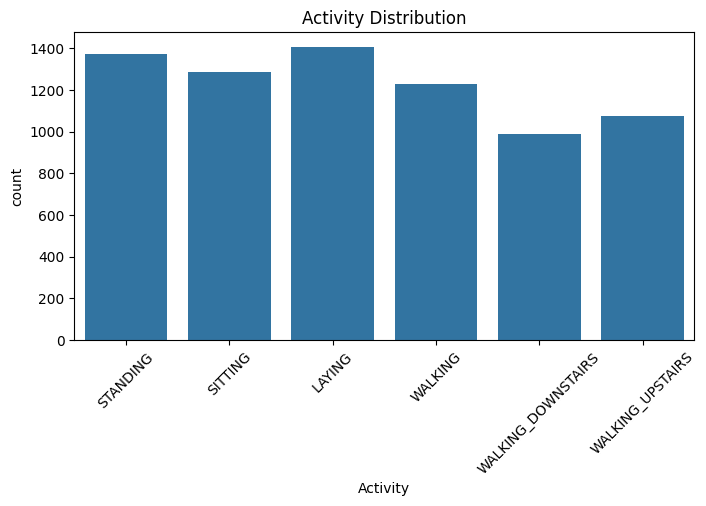

In [16]:
plt.figure(figsize=(8,4))
sns.countplot(x=train["Activity"])
plt.xticks(rotation=45)
plt.title("Activity Distribution")
plt.show()


# Separate labels and features

In [56]:
y_train = train["Activity"]
y_test  = test["Activity"]

X_train = train.drop(columns=["Activity", "subject"])
X_test  = test.drop(columns=["Activity", "subject"])

print(X_train.shape)


(7352, 561)


# Split modalities

In [55]:
acc_cols = [c for c in X_train.columns if "Acc" in c]
gyro_cols = [c for c in X_train.columns if "Gyro" in c]

X_acc_train = X_train[acc_cols].values
X_gyro_train = X_train[gyro_cols].values

X_acc_test = X_test[acc_cols].values
X_gyro_test = X_test[gyro_cols].values

print("Accel shape:", X_acc_train.shape)
print("Gyro shape:", X_gyro_train.shape)


Accel shape: (7352, 345)
Gyro shape: (7352, 213)


# Encode activity labels

In [25]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

n_classes = len(le.classes_)


# Scale each modality separately

In [26]:
scaler_acc = StandardScaler()
scaler_gyro = StandardScaler()

X_acc_train = scaler_acc.fit_transform(X_acc_train)
X_acc_test  = scaler_acc.transform(X_acc_test)

X_gyro_train = scaler_gyro.fit_transform(X_gyro_train)
X_gyro_test  = scaler_gyro.transform(X_gyro_test)


# single-modality model function

In [27]:
def build_single_model(input_dim, n_classes):
    inp = Input(shape=(input_dim,))
    x = Dense(128, activation="relu")(inp)
    x = Dropout(0.3)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    out = Dense(n_classes, activation="softmax")(x)
    
    model = Model(inp, out)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Train accelerometer model

In [28]:
acc_model = build_single_model(X_acc_train.shape[1], n_classes)

hist_acc = acc_model.fit(
    X_acc_train,
    y_train_enc,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

acc_loss, acc_acc = acc_model.evaluate(X_acc_test, y_test_enc)
print("Accelerometer accuracy:", acc_acc)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5875 - loss: 1.0565 - val_accuracy: 0.9225 - val_loss: 0.2537
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8646 - loss: 0.3532 - val_accuracy: 0.9273 - val_loss: 0.2065
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9030 - loss: 0.2513 - val_accuracy: 0.9293 - val_loss: 0.1792
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9156 - loss: 0.2047 - val_accuracy: 0.9157 - val_loss: 0.2106
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9286 - loss: 0.1766 - val_accuracy: 0.9279 - val_loss: 0.1948
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9401 - loss: 0.1550 - val_accuracy: 0.9279 - val_loss: 0.1928
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9480 - loss: 0.1446 - val_accuracy: 0.9273 - val_loss: 0.2087
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9447 - loss: 0.1403 - val_accuracy: 0.9279 - val_loss:

# Train gyroscope model

In [29]:
gyro_model = build_single_model(X_gyro_train.shape[1], n_classes)

hist_gyro = gyro_model.fit(
    X_gyro_train,
    y_train_enc,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

gyro_loss, gyro_acc = gyro_model.evaluate(X_gyro_test, y_test_enc)
print("Gyroscope accuracy:", gyro_acc)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4152 - loss: 1.4272 - val_accuracy: 0.6995 - val_loss: 0.7309
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6846 - loss: 0.7663 - val_accuracy: 0.7559 - val_loss: 0.5897
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7359 - loss: 0.6346 - val_accuracy: 0.7532 - val_loss: 0.5799
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7800 - loss: 0.5448 - val_accuracy: 0.7797 - val_loss: 0.5223
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7925 - loss: 0.5176 - val_accuracy: 0.7906 - val_loss: 0.5200
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8004 - loss: 0.4772 - val_accuracy: 0.7879 - val_loss: 0.5057
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8178 - loss: 0.4437 - val_accuracy: 0.7940 - val_loss: 0.5245
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8294 - loss: 0.4171 - val_accuracy: 0.7933 - val_loss:

# multimodal fusion model

In [30]:
def build_fusion_model(acc_dim, gyro_dim, n_classes):
    
    acc_input = Input(shape=(acc_dim,))
    acc_branch = Dense(128, activation="relu")(acc_input)
    acc_branch = Dropout(0.3)(acc_branch)
    
    gyro_input = Input(shape=(gyro_dim,))
    gyro_branch = Dense(128, activation="relu")(gyro_input)
    gyro_branch = Dropout(0.3)(gyro_branch)
    
    fusion = Concatenate()([acc_branch, gyro_branch])
    fusion = Dense(128, activation="relu")(fusion)
    fusion = Dropout(0.4)(fusion)
    
    out = Dense(n_classes, activation="softmax")(fusion)
    
    model = Model([acc_input, gyro_input], out)
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# Train multimodal model

In [31]:
fusion_model = build_fusion_model(
    X_acc_train.shape[1],
    X_gyro_train.shape[1],
    n_classes
)

hist_fusion = fusion_model.fit(
    [X_acc_train, X_gyro_train],
    y_train_enc,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

fusion_loss, fusion_acc = fusion_model.evaluate(
    [X_acc_test, X_gyro_test],
    y_test_enc
)

print("Fusion accuracy:", fusion_acc)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6229 - loss: 0.9312 - val_accuracy: 0.9177 - val_loss: 0.1997
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9108 - loss: 0.2429 - val_accuracy: 0.9368 - val_loss: 0.1456
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9448 - loss: 0.1494 - val_accuracy: 0.9429 - val_loss: 0.1225
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9529 - loss: 0.1240 - val_accuracy: 0.9361 - val_loss: 0.1614
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9679 - loss: 0.0859 - val_accuracy: 0.9415 - val_loss: 0.1254
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9716 - loss: 0.0759 - val_accuracy: 0.9572 - val_loss: 0.1110
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9684 - loss: 0.0817 - val_accuracy: 0.9531 - val_loss: 0.1185
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9749 - loss: 0.0669 - val_accuracy: 0.9395 - val_loss:

# Compare all models

In [32]:
results = pd.DataFrame({
    "Model": ["Accelerometer", "Gyroscope", "Multimodal Fusion"],
    "Test Accuracy": [acc_acc, gyro_acc, fusion_acc]
})

print(results)


               Model  Test Accuracy
0      Accelerometer       0.897862
1          Gyroscope       0.799118
2  Multimodal Fusion       0.935867


**bar chart:**

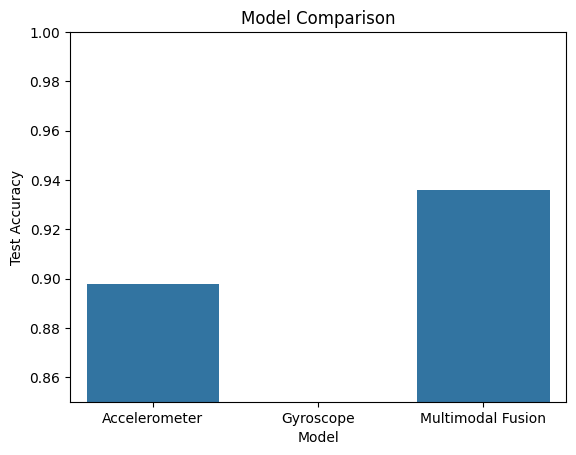

In [33]:
sns.barplot(x="Model", y="Test Accuracy", data=results)
plt.ylim(0.85, 1.0)
plt.title("Model Comparison")
plt.show()


# Predictions from all three models

In [34]:
# Accelerometer predictions
y_pred_acc = acc_model.predict(X_acc_test)
y_pred_acc_labels = np.argmax(y_pred_acc, axis=1)

# Gyroscope predictions
y_pred_gyro = gyro_model.predict(X_gyro_test)
y_pred_gyro_labels = np.argmax(y_pred_gyro, axis=1)

# Fusion predictions
y_pred_fusion = fusion_model.predict([X_acc_test, X_gyro_test])
y_pred_fusion_labels = np.argmax(y_pred_fusion, axis=1)


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Function to plot confusion matrix

In [35]:
def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=classes,
        yticklabels=classes
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


# Confusion matrices for all three models

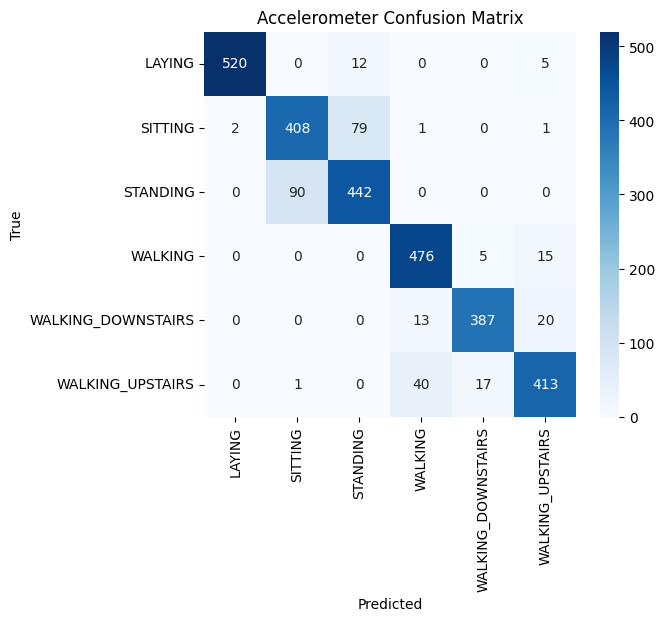

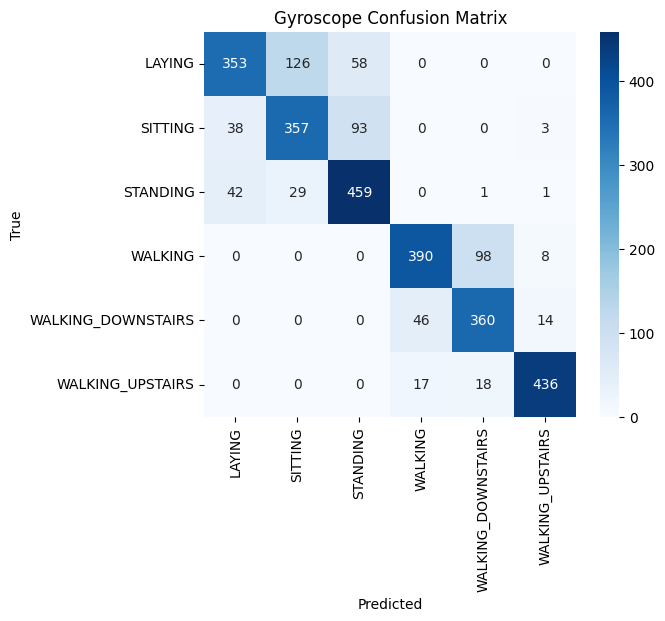

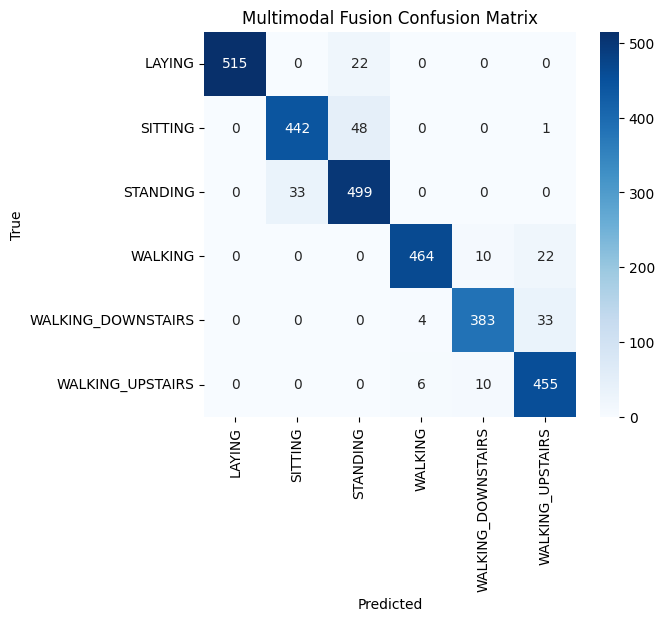

In [36]:
plot_cm(y_test_enc, y_pred_acc_labels, le.classes_, "Accelerometer Confusion Matrix")
plot_cm(y_test_enc, y_pred_gyro_labels, le.classes_, "Gyroscope Confusion Matrix")
plot_cm(y_test_enc, y_pred_fusion_labels, le.classes_, "Multimodal Fusion Confusion Matrix")


# McNemar test function

In [37]:
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, pred1, pred2, name1, name2):
    
    # contingency table
    correct1 = (pred1 == y_true)
    correct2 = (pred2 == y_true)
    
    n01 = np.sum((correct1 == 1) & (correct2 == 0))
    n10 = np.sum((correct1 == 0) & (correct2 == 1))
    
    table = [[0, n01],
             [n10, 0]]
    
    result = mcnemar(table, exact=True)
    
    print(f"{name1} vs {name2}")
    print("n01:", n01, " n10:", n10)
    print("p-value:", result.pvalue)
    
    if result.pvalue < 0.05:
        print("Difference is statistically significant\n")
    else:
        print("No significant difference\n")


In [38]:
mcnemar_test(y_test_enc, y_pred_acc_labels, y_pred_gyro_labels,
             "Accelerometer", "Gyroscope")

mcnemar_test(y_test_enc, y_pred_acc_labels, y_pred_fusion_labels,
             "Accelerometer", "Fusion")

mcnemar_test(y_test_enc, y_pred_gyro_labels, y_pred_fusion_labels,
             "Gyroscope", "Fusion")


Accelerometer vs Gyroscope
n01: 523  n10: 232
p-value: 1.1316998760926694e-26
Difference is statistically significant

Accelerometer vs Fusion
n01: 59  n10: 171
p-value: 7.90667983016135e-14
Difference is statistically significant

Gyroscope vs Fusion
n01: 93  n10: 496
p-value: 2.0310211560783497e-67
Difference is statistically significant



# Gradient Boosting

In [40]:
from xgboost import XGBClassifier


# Accelerometer model (XGBoost)

In [41]:
xgb_acc = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_acc.fit(X_acc_train, y_train_enc)

y_pred_acc = xgb_acc.predict(X_acc_test)
acc_acc = accuracy_score(y_test_enc, y_pred_acc)

print("XGB Accelerometer accuracy:", acc_acc)


XGB Accelerometer accuracy: 0.8975229046487954


# Gyroscope model (XGBoost)


In [42]:
xgb_gyro = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_gyro.fit(X_gyro_train, y_train_enc)

y_pred_gyro = xgb_gyro.predict(X_gyro_test)
gyro_acc = accuracy_score(y_test_enc, y_pred_gyro)

print("XGB Gyroscope accuracy:", gyro_acc)


XGB Gyroscope accuracy: 0.8554462164913471


# Multimodal fusion (XGBoost)

In [43]:
X_fusion_train = np.hstack([X_acc_train, X_gyro_train])
X_fusion_test  = np.hstack([X_acc_test, X_gyro_test])

xgb_fusion = XGBClassifier(
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=42
)

xgb_fusion.fit(X_fusion_train, y_train_enc)

y_pred_fusion = xgb_fusion.predict(X_fusion_test)
fusion_acc = accuracy_score(y_test_enc, y_pred_fusion)

print("XGB Fusion accuracy:", fusion_acc)


XGB Fusion accuracy: 0.9379029521547336


# SVF

# SVM: accelerometer

In [46]:
from sklearn.svm import SVC

svm_acc = SVC(
    kernel="rbf",
    C=10,
    gamma="scale"
)

svm_acc.fit(X_acc_train, y_train_enc)

y_pred_acc = svm_acc.predict(X_acc_test)
acc_acc = accuracy_score(y_test_enc, y_pred_acc)

print("SVM Accelerometer:", acc_acc)


SVM Accelerometer: 0.9134713267729895


# SVM: gyroscope

In [47]:
svm_gyro = SVC(
    kernel="rbf",
    C=10,
    gamma="scale"
)

svm_gyro.fit(X_gyro_train, y_train_enc)

y_pred_gyro = svm_gyro.predict(X_gyro_test)
gyro_acc = accuracy_score(y_test_enc, y_pred_gyro)

print("SVM Gyroscope:", gyro_acc)


SVM Gyroscope: 0.8028503562945368


# SVM: multimodal fusion

In [48]:
X_fusion_train = np.hstack([X_acc_train, X_gyro_train])
X_fusion_test  = np.hstack([X_acc_test, X_gyro_test])

svm_fusion = SVC(
    kernel="rbf",
    C=10,
    gamma="scale"
)

svm_fusion.fit(X_fusion_train, y_train_enc)

y_pred_fusion = svm_fusion.predict(X_fusion_test)
fusion_acc = accuracy_score(y_test_enc, y_pred_fusion)

print("SVM Fusion:", fusion_acc)


SVM Fusion: 0.9538513742789277


In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [1, 5, 10, 20],
    "gamma": ["scale", 0.01, 0.005]
}

grid = GridSearchCV(
    SVC(kernel="rbf"),
    param_grid,
    cv=3,
    n_jobs=-1
)

grid.fit(X_fusion_train, y_train_enc)

print("Best params:", grid.best_params_)
print("CV accuracy:", grid.best_score_)

svm_fusion = grid.best_estimator_
fusion_acc = accuracy_score(y_test_enc,
                            svm_fusion.predict(X_fusion_test))

print("Tuned SVM Fusion:", fusion_acc)


Best params: {'C': 5, 'gamma': 'scale'}
CV accuracy: 0.9326731557576111
Tuned SVM Fusion: 0.9535120461486257


# COMAPARISON

In [50]:
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "XGB Accelerometer",
        "XGB Gyroscope",
        "XGB Fusion",
        "SVM Accelerometer",
        "SVM Gyroscope",
        "SVM Fusion"
    ],
    "Accuracy": [
        0.8975229046487954,
        0.8554462164913471,
        0.9379029521547336,
        0.9134713267729895,
        0.8028503562945368,
        0.9538513742789277
    ]
})

results = results.sort_values(by="Accuracy", ascending=False)
results.reset_index(drop=True, inplace=True)

print(results)


               Model  Accuracy
0         SVM Fusion  0.953851
1         XGB Fusion  0.937903
2  SVM Accelerometer  0.913471
3  XGB Accelerometer  0.897523
4      XGB Gyroscope  0.855446
5      SVM Gyroscope  0.802850


In [54]:
best_model = results.iloc[0]

print("Best Model:", best_model["Model"])
print("Accuracy:", best_model["Accuracy"])


Best Model: SVM Fusion
Accuracy: 0.9538513742789277


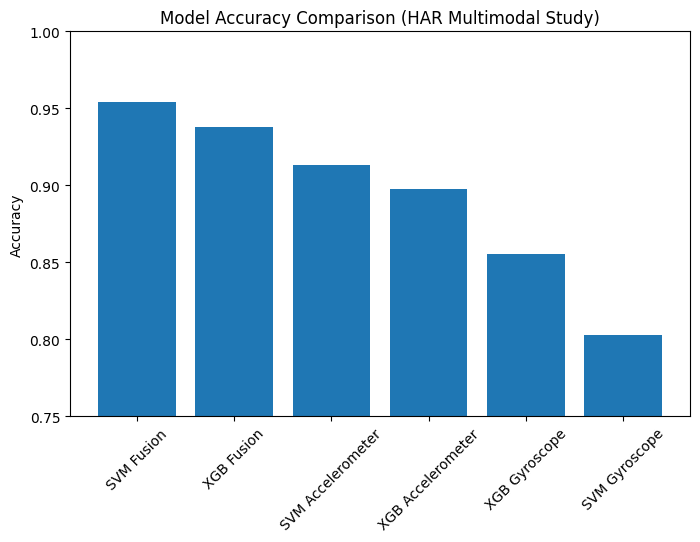

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(results["Model"], results["Accuracy"])
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (HAR Multimodal Study)")
plt.ylim(0.75, 1.0)
plt.show()


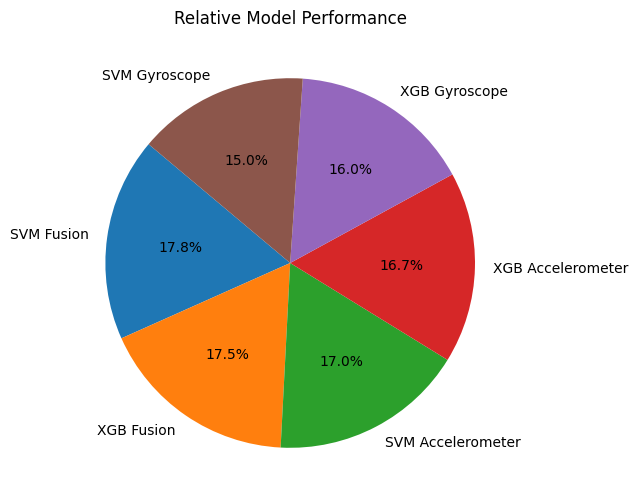

In [52]:
plt.figure(figsize=(6,6))
plt.pie(
    results["Accuracy"],
    labels=results["Model"],
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Relative Model Performance")
plt.show()
